## Libraries

In [3]:
# General
from __future__ import print_function, division
import numpy as np
import pandas as pd
import time
import os
import pickle

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch.nn.functional as F

# Metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import confusion_matrix, average_precision_score

# Tracking progress
from tqdm import tqdm

# Set Seed
torch.manual_seed(2021)

plt.ion()   # interactive mode

# To GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

Note that each model was trained on data of a different format.  The baseline CNN was trained on images as numpy files and ResNet18 was trained on PIL images.  The test data are identical.

In [10]:
# For Baseline CNN
folder = '/home/ubuntu/numpy-files/'
batch_size = 150

test_X = np.load(folder +'test_X.npy')
test_y = np.load(folder +'test_y.npy')

test_X = test_X.reshape(len(test_X), 1, 256, 256)

test_seq_CNN = torch.from_numpy(test_X).float()
test_y_CNN = torch.tensor(test_y).type(torch.LongTensor)

test_data_CNN = TensorDataset(test_seq_CNN, test_y_CNN)
test_sampler_CNN = RandomSampler(test_data_CNN)
test_dataloader_CNN = DataLoader(test_data_CNN, sampler=test_sampler_CNN, batch_size=batch_size)

In [11]:
# For SqueezeNet and ResNet18
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/ubuntu/data/2A_images_reorg'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes

## Load Models

In [12]:
class CNN(nn.Module):

    def __init__(self,
                 filter_sizes,
                 num_filters,
                 fc1_neurons,
                 fc2_neurons):

        super(CNN, self).__init__()

        # Conv Network
        self.conv2d_list = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])

        # RELU activation function
        self.relu =  nn.ReLU()

        # Fully-connected layers
        self.fc1 = nn.Linear(np.sum(num_filters), fc1_neurons)

        if fc2_neurons != None:

            # print('fc2=None')

            self.fc2 = nn.Linear(fc1_neurons, fc2_neurons)

            self.fc3 = nn.Linear(fc2_neurons, 3)

        else:

            self.fc2 = nn.Linear(fc1_neurons, 3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs):

        # Apply CNN and ReLU.
        x_conv_list = [self.relu(conv2d(inputs)) for conv2d in self.conv2d_list]



        # Max pooling.
        x_pool_list = [F.max_pool2d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # print(x_pool_list[0].shape)
        # print(x_pool_list[0].squeeze(32).shape)
        # print(x_pool_list[0].squeeze(3).shape)
        # Concatenate x_pool_list to feed the fully connected layer.
        x_fc = torch.cat([x_pool.squeeze(2).squeeze(2) for x_pool in x_pool_list],
                         dim=1)

        x = self.fc1(x_fc)
        x = self.relu(x)

        x = self.fc2(x)

        try:
            if self.fc3 != None:

                x = self.relu(x)
                x = self.fc3(x)

        except:
            pass


        probs = self.softmax(x)

        return probs
    
# Model Initializiation
CNN_Model = CNN(filter_sizes = [2, 3, 4], 
                num_filters = [25,25,25],
                fc1_neurons = 200,
                fc2_neurons = 50
                )

In [23]:
# Load pretratined model into SqueezeNet_1.0
SQN_Model = models.squeezenet1_0(pretrained=True)
num_classes = 3
SQN_Model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
SQN_Model.num_classes = num_classes

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [25]:
# Load pretratined model into resnet18
RN18_Model = models.resnet18(pretrained=True)
num_ftrs = RN18_Model.fc.in_features
RN18_Model.fc = nn.Linear(num_ftrs, 3)

## Load Weights

In [26]:
# Baseline CNN
PATH1 = '/home/ubuntu/MIDS-251-2021-Final-Project/CNN/CNN_Weights_Run_1'
CNN_Model.load_state_dict(torch.load(PATH1))
CNN_Model = CNN_Model.to(device)

# SqueezeNet
PATH2 = '/home/ubuntu/MIDS-251-2021-Final-Project/SqueezeNet/SqueezeNet_weights_full'
SQN_Model.load_state_dict(torch.load(PATH2))
SQN_Model = SQN_Model.to(device)

# ResNet18
PATH3 = '/home/ubuntu/MIDS-251-2021-Final-Project/ResNet18/ResNet18_weights_full'
RN18_Model.load_state_dict(torch.load(PATH3))
RN18_Model = RN18_Model.to(device)

## Load Prediction Functions

In [27]:
def evaluate_CNN(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    #val_accuracy = []
    #val_loss = []
    total_probs = []
    total_preds = []
    total_labels = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to CPU
        data, labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            probs = model(data)
            
        total_probs.append(probs)

        # Compute loss
        #loss = cross_entropy(probs, labels)
        #val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(probs, dim=1).flatten()
        total_preds.append(preds)
        total_labels.append(labels)

        # Calculate the accuracy rate
        #accuracy = (preds == labels).cpu().numpy().mean() * 100
        #val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    #val_loss = np.mean(val_loss)
    #val_accuracy = np.mean(val_accuracy)

    #return val_loss, val_accuracy, total_probs, total_preds, total_labels
    return total_probs, total_preds, total_labels

In [28]:
def visualize_model(model, pred_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    eval_history = {'predict':[], 'actual':[], 'prob':[]}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far < pred_images:
                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                    eval_history['prob'].append(prob[j].cpu().numpy().tolist())
                    
                elif images_so_far == pred_images:
                    model.train(mode=was_training)
                    return eval_history
        model.train(mode=was_training)

## Prediction on Test Set

In [29]:
# Baseline CNN
total_probs_CNN, total_preds_CNN, \
total_labels_CNN = evaluate_CNN(model = CNN_Model, 
                                val_dataloader = test_dataloader_CNN)

total_labels_CNN_Cat = torch.cat(total_labels_CNN).cpu().numpy()
total_probs_CNN_Cat = torch.cat(total_probs_CNN).cpu().numpy()
total_preds_CNN_Cat = torch.cat(total_preds_CNN).cpu().numpy()

In [30]:
# SqueezeNet
SQN_eval_history = visualize_model(SQN_Model, pred_images=dataset_sizes['test'])

<Figure size 432x288 with 0 Axes>

In [31]:
# ResNet18
RN18_eval_history = visualize_model(RN18_Model, pred_images=dataset_sizes['test'])

<Figure size 432x288 with 0 Axes>

## Classification Report

In [32]:
# Baseline CNN
print(classification_report(total_labels_CNN_Cat, total_preds_CNN_Cat, digits=3))

              precision    recall  f1-score   support

           0      0.932     0.955     0.943      6032
           1      0.931     0.953     0.942      4027
           2      0.992     0.966     0.979      9433

    accuracy                          0.960     19492
   macro avg      0.952     0.958     0.955     19492
weighted avg      0.961     0.960     0.960     19492



In [33]:
# SqueezeNet
print(classification_report(SQN_eval_history['actual'], SQN_eval_history['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.998     0.994     0.996      9336
      Normal      0.994     0.999     0.996      6057
   Pneumonia      0.993     0.994     0.994      4098

    accuracy                          0.995     19491
   macro avg      0.995     0.996     0.995     19491
weighted avg      0.995     0.995     0.995     19491



In [35]:
# ResNet18
print(classification_report(RN18_eval_history['actual'], RN18_eval_history['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.997     0.998     0.997      9335
      Normal      0.998     0.998     0.998      6058
   Pneumonia      0.997     0.995     0.996      4098

    accuracy                          0.997     19491
   macro avg      0.997     0.997     0.997     19491
weighted avg      0.997     0.997     0.997     19491



## Precision-Recall

Get the probabilities

In [36]:
# Baseline CNN
Normal_Prob_CNN = np.array(total_probs_CNN_Cat)[:,0]
Pneumonia_Prob_CNN = np.array(total_probs_CNN_Cat)[:,1]
Covid_Prob_CNN = np.array(total_probs_CNN_Cat)[:,2]

In [37]:
# SqueezeNet
Normal_Prob_SQN = [i[1] for i in SQN_eval_history['prob']]
Pneumonia_Prob_SQN = [i[2] for i in SQN_eval_history['prob']]
Covid_Prob_SQN = [i[0] for i in SQN_eval_history['prob']]

In [38]:
# Resnet18
Normal_Prob_RN18 = [i[1] for i in RN18_eval_history['prob']]
Pneumonia_Prob_RN18 = [i[2] for i in RN18_eval_history['prob']]
Covid_Prob_RN18 = [i[0] for i in RN18_eval_history['prob']]

Calculate fraction of majority class for reference

In [39]:
no_skill = np.max(np.unique(test_y, return_counts=True)[1]/(np.unique(test_y, return_counts=True)[1].sum()))

Precision Recall curves for each model

In [49]:
# Baseline CNN
Normal_precision_CNN, Normal_recall_CNN, _ = \
precision_recall_curve(total_labels_CNN_Cat, Normal_Prob_CNN, pos_label=0)

Pneumonia_precision_CNN, Pneumonia_recall_CNN, _ = \
precision_recall_curve(total_labels_CNN_Cat, Pneumonia_Prob_CNN , pos_label=1)

Covid_precision_CNN, Covid_recall_CNN, _ = \
precision_recall_curve(total_labels_CNN_Cat, Covid_Prob_CNN, pos_label=2)

In [50]:
# SqueezeNet
Normal_precision_SQN, Normal_recall_SQN, _ = \
precision_recall_curve(SQN_eval_history['actual'], Normal_Prob_SQN, pos_label='Normal')

Pneumonia_precision_SQN, Pneumonia_recall_SQN, _ = \
precision_recall_curve(SQN_eval_history['actual'], Pneumonia_Prob_SQN, pos_label='Pneumonia')

Covid_precision_SQN, Covid_recall_SQN, _ = \
precision_recall_curve(SQN_eval_history['actual'], Covid_Prob_SQN, pos_label='Covid')

In [51]:
# ResNet18
Normal_precision_RN18, Normal_recall_RN18, _ = \
precision_recall_curve(RN18_eval_history['actual'], Normal_Prob_RN18, pos_label='Normal')

Pneumonia_precision_RN18, Pneumonia_recall_RN18, _ = \
precision_recall_curve(RN18_eval_history['actual'], Pneumonia_Prob_RN18, pos_label='Pneumonia')

Covid_precision_RN18, Covid_recall_RN18, _ = \
precision_recall_curve(RN18_eval_history['actual'], Covid_Prob_RN18, pos_label='Covid')

Curves

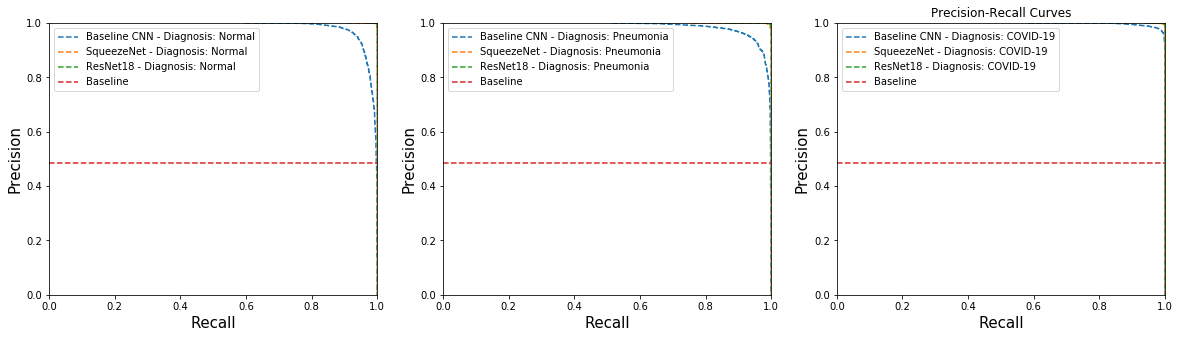

In [53]:
# Plot precision-recall curves for all classes for each model
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].plot(Normal_precision_CNN, Normal_recall_CNN, linestyle='--',  label='Baseline CNN - Diagnosis: Normal')
ax[1].plot(Pneumonia_precision_CNN, Pneumonia_recall_CNN, linestyle='--',  label='Baseline CNN - Diagnosis: Pneumonia')
ax[2].plot(Covid_precision_CNN, Covid_recall_CNN, linestyle='--',  label='Baseline CNN - Diagnosis: COVID-19')

ax[0].plot(Normal_precision_SQN, Normal_recall_SQN, linestyle='--',  label='SqueezeNet - Diagnosis: Normal')
ax[1].plot(Pneumonia_precision_SQN, Pneumonia_recall_SQN, linestyle='--',  label='SqueezeNet - Diagnosis: Pneumonia')
ax[2].plot(Covid_precision_SQN, Covid_recall_SQN, linestyle='--',  label='SqueezeNet - Diagnosis: COVID-19')

ax[0].plot(Normal_precision_RN18, Normal_recall_RN18, linestyle='--',  label='ResNet18 - Diagnosis: Normal')
ax[1].plot(Pneumonia_precision_RN18, Pneumonia_recall_RN18, linestyle='--',  label='ResNet18 - Diagnosis: Pneumonia')
ax[2].plot(Covid_precision_RN18, Covid_recall_RN18, linestyle='--',  label='ResNet18 - Diagnosis: COVID-19')

ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
ax[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')

# axis labels
ax[0].set_xlabel('Recall', size = 15)
ax[0].set_ylabel('Precision', size = 15)
ax[1].set_xlabel('Recall', size = 15)
ax[1].set_ylabel('Precision', size = 15)
ax[2].set_xlabel('Recall', size = 15)
ax[2].set_ylabel('Precision', size = 15)

plt.title('Precision-Recall Curves')

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, 1)
# show the legend
ax[0].legend()
ax[1].legend()
ax[2].legend()
# show the plot
plt.show()

## Training Metrics

The training metrics for the ResNet18 model was not saved and are manually entered.

In [159]:
train_dict_CNN = pd.read_pickle('/home/ubuntu/MIDS-251-2021-Final-Project/trainig_dict_CNN_Run_1')
train_dict_R18_mini = {'epoch':[], 'train loss':[], 'val loss':[], 'val acc':[]}
train_dict_R18_full = {'epoch':[], 'train loss':[], 'val loss':[], 'val acc':[]}

train_dict_R18_mini['epoch'] = np.linspace(0, 14, 15)
train_dict_R18_mini['train loss'] = [0.6414, 0.4392, 0.3561, 0.3071, 0.2695,
                                     0.2408, 0.2312, 0.1507, 0.1331, 0.1207,
                                     0.1144, 0.1256, 0.1173, 0.1109, 0.1028]
train_dict_R18_mini['val loss'] = [0.3111, 0.1142, 0.1242, 0.3281, 0.2270,
                                   0.0956, 0.0659, 0.2649, 0.0694, 0.0603,
                                   0.0514, 0.0499, 0.0519, 0.0586, 0.0492]
train_dict_R18_mini['val acc'] = [0.8916, 0.966, 0.9605, 0.8776, 0.9201, 
                                  0.9701,0.9778, 0.9073, 0.9772, 0.9827, 
                                  0.9848, 0.9846, 0.9854, 0.9819, 0.9853]

train_dict_R18_full['epoch'] = np.linspace(0, 14, 15)
train_dict_R18_full['train loss'] = [0.2647, 0.1181, 0.0935, 0.0805, 0.0710, 
                                     0.0645, 0.0607, 0.0418, 0.0317, 0.0351, 
                                     0.0345, 0.0329, 0.0330, 0.0317, 0.0302]
train_dict_R18_full['val loss'] = [0.0516, 0.0342, 0.0435, 0.0268, 0.0252,
                                   0.0186, 0.0170, 0.0133, 0.0102, 0.0109,
                                   0.0096, 0.0093, 0.0092, 0.0092, 0.0096]
train_dict_R18_full['val acc'] = [0.9838, 0.9892, 0.9850, 0.9915, 0.9918,
                                  0.9946, 0.9946, 0.9957, 0.9972, 0.9971, 
                                  0.9976, 0.9972, 0.9978, 0.9973, 0.9975]

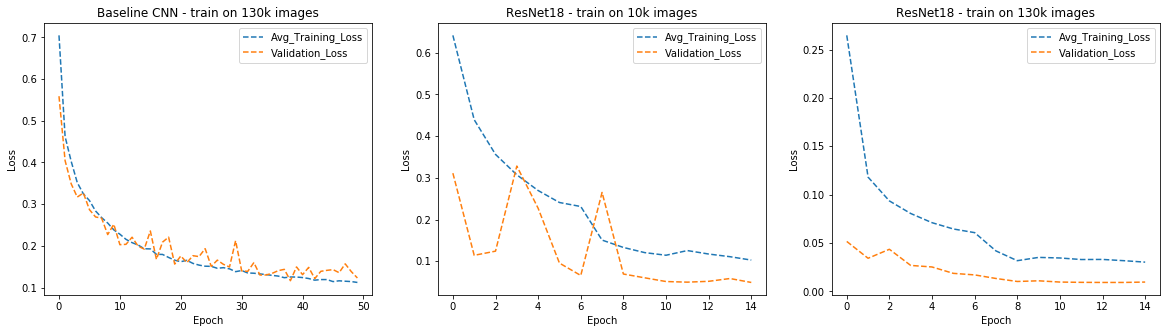

In [182]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

#  Loss
ax[0].plot(train_dict_CNN[1]['Epoch'], train_dict_CNN[1]['Avg_Training_Loss'], 
           label='Avg_Training_Loss', linestyle='--')
ax[0].plot(train_dict_CNN[1]['Epoch'],train_dict_CNN[1]['Validation_Loss'], 
           label='Validation_Loss', linestyle='--')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Baseline CNN - train on 130k images')
ax[0].legend()


ax[1].plot(train_dict_R18_mini['epoch'], train_dict_R18_mini['train loss'], 
           label='Avg_Training_Loss', linestyle='--')
ax[1].plot(train_dict_R18_mini['epoch'], train_dict_R18_mini['val loss'], 
           label='Validation_Loss', linestyle='--')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('ResNet18 - train on 10k images')
ax[1].legend()


ax[2].plot(train_dict_R18_full['epoch'], train_dict_R18_full['train loss'], 
           label='Avg_Training_Loss', linestyle='--')
ax[2].plot(train_dict_R18_full['epoch'], train_dict_R18_full['val loss'], 
           label='Validation_Loss', linestyle='--')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('ResNet18 - train on 130k images')
ax[2].legend()


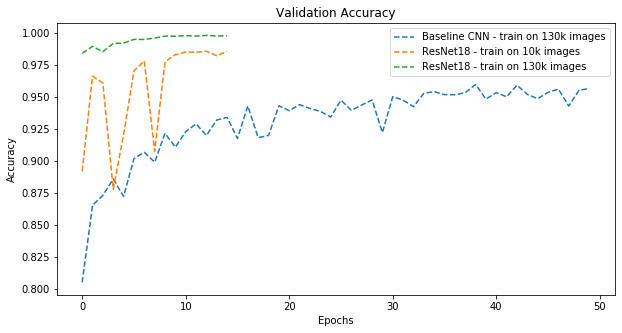

In [192]:
fig, ax = plt.subplots(figsize=(10,5))

# Accuracy
plt.plot(train_dict_CNN[1]['Epoch'], np.array(train_dict_CNN[1]['Validation_Accuracy'])/100, 
           label='Baseline CNN - train on 130k images', linestyle='--')
plt.plot(train_dict_R18_mini['epoch'], train_dict_R18_mini['val acc'], 
           label='ResNet18 - train on 10k images', linestyle='--')
plt.plot(train_dict_R18_full['epoch'], train_dict_R18_full['val acc'], 
           label='ResNet18 - train on 130k images', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()